In [44]:
'''
PCA_TSFEL for Patient 9
'''
# Import Functions
import sys
sys.path.insert(0, r'C:\Users\sidha\OneDrive\Sid Stuff\PROJECTS\iMEDS Design Team\Data Analysis\PedAccel\data_analysis\PythonPipeline\Modules')
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tsfel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
import matplotlib.lines as mlines
from scipy.io import loadmat
from operator import itemgetter
from math import isnan
import Actigraph_Metrics

In [51]:
# Load Data
os.chdir(r'C:\Users\sidha\OneDrive\Sid Stuff\PROJECTS\iMEDS Design Team\Data Analysis\PedAccel\data_analysis\PythonPipeline\PatientData\Patient9')

filename = 'Patient9_5MIN_DSW_AllSBS.mat'
x_mag = (loadmat(filename)["x_mag"])
SBS = loadmat(filename)["sbs"]

# Generate configuration file for feature extraction
cfg_file = tsfel.get_features_by_domain()

print(x_mag)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [46]:
# Extract features and restructure data
features_list = []
sbs_list = []
for i in range(x_mag.shape[0]):
    signal = Actigraph_Metrics.VecMag_MAD(x_mag[i,:],100)
    features = tsfel.time_series_features_extractor(cfg_file, signal, fs=100, verbose=0)
    features_list.append(features)
    sbs_list.append(SBS[0][i])

In [47]:
# Convert features and SBS scores to DataFrame
features_array = np.array(features_list).reshape(-1, 389)
df_features = pd.DataFrame(features_array)
df_features.columns = ['feature_' + str(col) for col in df_features.columns]

df_sbs = pd.DataFrame({'SBS': sbs_list})

# Concatenate features and SBS scores
df = pd.concat([df_sbs, df_features], axis=1)
x = df_features.values
y = df['SBS'].values

In [48]:
# Normalize features
x = df.iloc[:, 1:].values
x_normalized = StandardScaler().fit_transform(x)
print(x)

[[2.37554488e-03 8.32944978e-04 2.37554488e-03 ... 1.13280049e-05
  1.13849128e-05 2.00000000e+00]
 [2.13036307e-03 4.61558563e-04 2.13036307e-03 ... 3.56248005e-06
  3.56248005e-06 2.00000000e+00]
 [2.04300999e-03 1.19197464e-03 2.04300999e-03 ... 6.69884539e-06
  6.58981138e-06 1.40000000e+01]
 ...
 [7.66651734e-04 5.65318168e-04 7.66651734e-04 ... 2.64141731e-06
  2.65180188e-06 8.00000000e+00]
 [4.27914957e-05 9.89676156e-05 4.27914957e-05 ... 7.04323864e-08
  6.28960346e-08 6.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [49]:
# Perform PCA Using All Features
pca_actigraphy = PCA(n_components=4)
principalComponents_actigraphy = pca_actigraphy.fit_transform(x_normalized)
principal_actigraphy_Df = pd.DataFrame(data=principalComponents_actigraphy,
                                      columns=['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])

print('Explained variation per principal component: {}'.format(pca_actigraphy.explained_variance_ratio_))

# Plot PCA for each principal component
for component in range(pca_actigraphy.n_components_ - 1):
    plt.figure(figsize=(8, 6))
    plt.xlabel(f'Principal Component - {component+1}', fontsize=12)
    plt.ylabel('Principal Component - {}'.format(component+2), fontsize=12)
    plt.title("Principal Component Analysis of Actigraphy and SBS", fontsize=14)
    
    for i in range(len(df_sbs)):
        if df['SBS'][i] == -1:
            color = 'purple'
        elif df['SBS'][i] == 0:
            color = 'blue'
        elif df['SBS'][i] == 1:
            color = 'orange'
        elif df['SBS'][i] == 2:
            color = 'red'
        plt.scatter(principal_actigraphy_Df.loc[i, f'principal component {component+1}'], 
                    principal_actigraphy_Df.loc[i, f'principal component {component+2}'], 
                    c=color, s=50)
    
    # Manually create a legend
    neg1 = mlines.Line2D([], [], color='purple', marker='o', ls='', label='SBS -1')
    zero = mlines.Line2D([], [], color='blue', marker='o', ls='', label='SBS 0')
    one = mlines.Line2D([], [], color='orange', marker='o', ls='', label='SBS 1')
    two = mlines.Line2D([], [], color='red', marker='o', ls='', label='SBS 2')
    plt.legend(handles=[neg1, zero, one, two])
    
    plt.show()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
# Perform PCA for Top 10 Features
pca_actigraphy = PCA(n_components=4)
principalComponents_actigraphy = pca_actigraphy.fit_transform(x_normalized)
print('Explained variation per principal component: {}'.format(pca_actigraphy.explained_variance_ratio_))

Explained variation per principal component: [0.59418551 0.11619511 0.07071909 0.05261507]


In [ ]:
# Get the absolute values of the elements in the eigenvectors
abs_eigenvectors = np.abs(pca_actigraphy.components_)

# Flatten the absolute values and get the indices of the top 10 features
top_features_indices = np.argsort(abs_eigenvectors.ravel())[::-1][:10]

# Convert the indices to row and column indices in the eigenvectors matrix
top_features_row_indices, top_features_col_indices = np.unravel_index(top_features_indices, abs_eigenvectors.shape)

# Get the names of the top 10 features
top_features = df_features.columns[top_features_col_indices]

# Print the top features
print("Top 10 Features from PCA:")
print(top_features)

Top 10 Features from PCA:
Index(['feature_22', 'feature_205', 'feature_44', 'feature_7', 'feature_33',
       'feature_140', 'feature_321', 'feature_250', 'feature_312',
       'feature_45'],
      dtype='object')


In [ ]:
# Names of Top 10 Features
y = top_features
for i, df in enumerate(features_list):
    first_row = df.iloc[0]
stripped_feature_names_list = [feature.replace("feature_", "") for feature in top_features]
for feature_name in stripped_feature_names_list:
    print(f"Feature name: {first_row.index[int(feature_name)]}")

Feature name: 0_FFT mean coefficient_10
Feature name: 0_FFT mean coefficient_35
Feature name: 0_FFT mean coefficient_12
Feature name: 0_ECDF Percentile_0
Feature name: 0_FFT mean coefficient_11
Feature name: 0_FFT mean coefficient_206
Feature name: 0_Median
Feature name: 0_FFT mean coefficient_76
Feature name: 0_MFCC_8
Feature name: 0_FFT mean coefficient_120


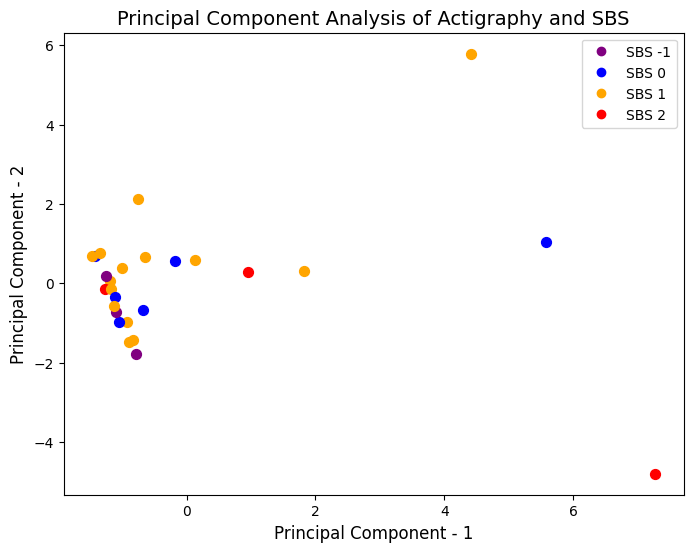

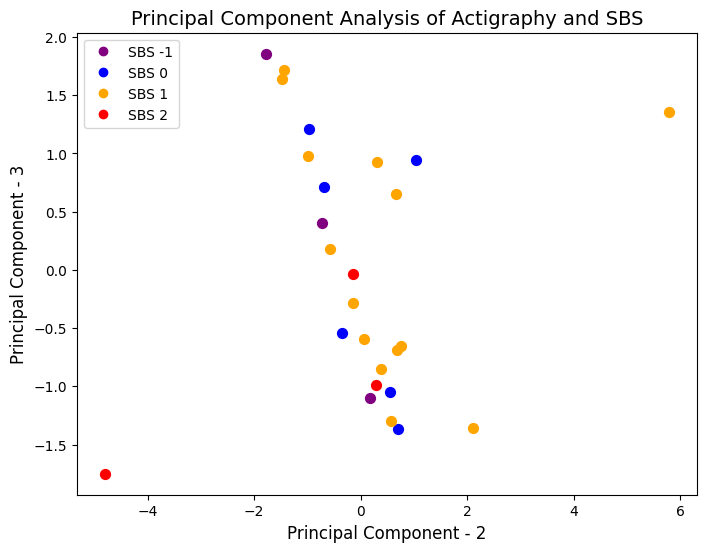

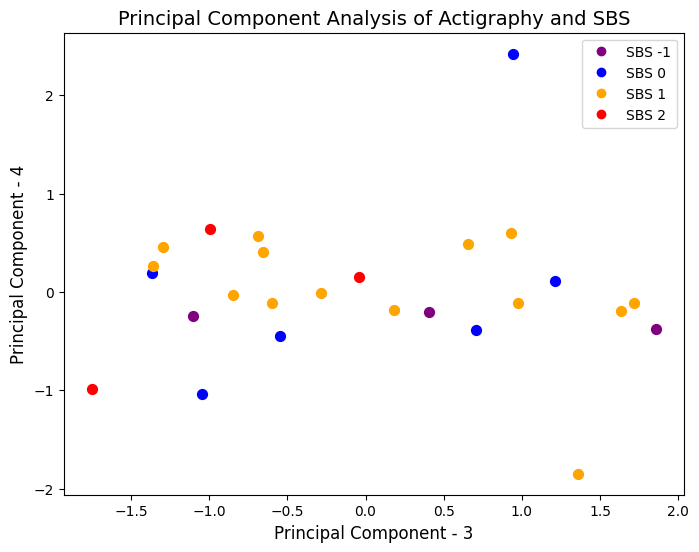

In [ ]:
# Perform PCA using only the top 10 features
pca_actigraphy_top10 = PCA(n_components=4)
principalComponents_actigraphy_top10 = pca_actigraphy_top10.fit_transform(x_normalized[:, top_features_col_indices])

# Create DataFrame for principal components with only top 10 features
principal_actigraphy_top10_Df = pd.DataFrame(data=principalComponents_actigraphy_top10,
                                             columns=['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])

# Plot PCA for each principal component
for component in range(pca_actigraphy_top10.n_components_ - 1):
    plt.figure(figsize=(8, 6))
    plt.xlabel(f'Principal Component - {component+1}', fontsize=12)
    plt.ylabel('Principal Component - {}'.format(component+2), fontsize=12)
    plt.title("Principal Component Analysis of Actigraphy and SBS", fontsize=14)
    
    for i in range(len(df_sbs)):
        if df_sbs['SBS'][i] == -1:
            color = 'purple'
        elif df_sbs['SBS'][i] == 0:
            color = 'blue'
        elif df_sbs['SBS'][i] == 1:
            color = 'orange'
        elif df_sbs['SBS'][i] == 2:
            color = 'red'
        plt.scatter(principal_actigraphy_top10_Df.loc[i, f'principal component {component+1}'], 
                    principal_actigraphy_top10_Df.loc[i, f'principal component {component+2}'], 
                    c=color, s=50)
    
    # Manually create a legend
    neg1 = mlines.Line2D([], [], color='purple', marker='o', ls='', label='SBS -1')
    zero = mlines.Line2D([], [], color='blue', marker='o', ls='', label='SBS 0')
    one = mlines.Line2D([], [], color='orange', marker='o', ls='', label='SBS 1')
    two = mlines.Line2D([], [], color='red', marker='o', ls='', label='SBS 2')
    plt.legend(handles=[neg1, zero, one, two])
    
    plt.show()
